#Test


In [227]:
from sklearn import preprocessing
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import prince
import seaborn as sns
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
%matplotlib inline

First we read the data and view the data

In [228]:
data = pd.read_csv(r'players_20.csv')
data.head()

,sofifa_id,short_name,nationality,club,overall,potential,team_position,age,height_cm,weight_kg,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,190871,Neymar Jr,Brazil,Paris Saint-Germain,92,92,CAM,27,175,68,...,90,94,27,26,29,9,9,15,15,11
1,192985,K. De Bruyne,Belgium,Manchester City,91,91,RCM,28,181,70,...,79,91,68,58,51,15,13,5,10,13
2,177003,L. Modrić,Croatia,Real Madrid,90,90,RCM,33,172,66,...,82,92,68,76,71,13,9,7,14,9
3,215914,N. Kanté,France,Chelsea,89,90,RCM,28,168,72,...,54,85,90,91,85,15,12,10,7,10
4,189511,Sergio Busquets,Spain,FC Barcelona,89,89,CDM,30,189,76,...,60,93,90,86,80,5,8,13,9,13


In [229]:
def get_cat(series: pd.Series, empty_flag: bool) -> str:
    """
    :param series: a pandas series of data (should be of one data type)
    :param empty_flag: a boolean to call out an empty column (containing all NaNs)
    :return: a string that is the 'category of the datatype'

    This function will take a given series and return a generalized category for the datatype.
    This is necessary for readability as df.dtypes will return ungrouped types (i.e. float64, int64)
    as well as return some options that do not provide much insight (i.e. object)
    """
    if empty_flag:  # Catch Empty Columns
        return 'Empty'
    elif pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif pd.api.types.is_bool_dtype(series):
        return 'Boolean'
    elif pd.api.types.is_categorical_dtype(series):
        return 'Categorical'
    elif pd.api.types.is_string_dtype(series):
        return 'Text'
    else:  # Catches all others for review
        return 'Unknown'


def col_categories(data: pd.DataFrame):
    """
    :param data: a pandas Dataframe consisting of columns of data you want to explore their categories
    :return: None
    Prints the column name and data type of each column in the dataframe
    """
    # if data.dropna().empty:  # Catches Error
    #     raise ValueError('DataFrame Provided Contains is either empty or only contains NaNs')
    #     # sys.exit(1)
    for col in data.columns:  # For Each Column
        if data[col].dropna().empty:  # Catch Empty Columns
            empty = True  # Set Flag
        else:
            empty = False  # Set Flag
        count = data[col].nunique()
        print(col, ': ', get_cat(data[col], empty), ' -- #Unique: ', count)  # Print and Call Column Categories

In [230]:
col_categories(data)






sofifa_id :  Numerical  -- #Unique:  608
short_name :  Text  -- #Unique:  603
nationality :  Text  -- #Unique:  70
club :  Text  -- #Unique:  274
overall :  Numerical  -- #Unique:  28
potential :  Numerical  -- #Unique:  20
team_position :  Text  -- #Unique:  11
age :  Numerical  -- #Unique:  20
height_cm :  Numerical  -- #Unique:  34
weight_kg :  Numerical  -- #Unique:  33
player_traits :  Text  -- #Unique:  212
attacking_crossing :  Numerical  -- #Unique:  54
attacking_finishing :  Numerical  -- #Unique:  59
attacking_heading_accuracy :  Numerical  -- #Unique:  55
attacking_short_passing :  Numerical  -- #Unique:  36
attacking_volleys :  Numerical  -- #Unique:  59
skill_dribbling :  Numerical  -- #Unique:  42
skill_curve :  Numerical  -- #Unique:  59
skill_fk_accuracy :  Numerical  -- #Unique:  65
skill_long_passing :  Numerical  -- #Unique:  48
skill_ball_control :  Numerical  -- #Unique:  37
movement_acceleration :  Numerical  -- #Unique:  55
movement_sprint_speed :  Numerical  -- 

Explain what we see, flags as numerical (but are binary) should be fine in our cluster

Lets look through a few of the variables to see the distribution (numerical with few options so
that our visuals are clean)





In [231]:
player = data[['sofifa_id', 'short_name', 'nationality','club',	'overall', 'potential',	'team_position']]

data = pd.concat([data,data.player_traits.str.get_dummies(sep=',').rename(lambda c: 'trait_' + c, axis='columns')],
                 axis=1)

data.drop(columns=['short_name', 'player_traits', 'nationality','club',	'overall', 'potential',	'team_position'], inplace=True)


col_categories(data)


sofifa_id :  Numerical  -- #Unique:  608
age :  Numerical  -- #Unique:  20
height_cm :  Numerical  -- #Unique:  34
weight_kg :  Numerical  -- #Unique:  33
attacking_crossing :  Numerical  -- #Unique:  54
attacking_finishing :  Numerical  -- #Unique:  59
attacking_heading_accuracy :  Numerical  -- #Unique:  55
attacking_short_passing :  Numerical  -- #Unique:  36
attacking_volleys :  Numerical  -- #Unique:  59
skill_dribbling :  Numerical  -- #Unique:  42
skill_curve :  Numerical  -- #Unique:  59
skill_fk_accuracy :  Numerical  -- #Unique:  65
skill_long_passing :  Numerical  -- #Unique:  48
skill_ball_control :  Numerical  -- #Unique:  37
movement_acceleration :  Numerical  -- #Unique:  55
movement_sprint_speed :  Numerical  -- #Unique:  60
movement_agility :  Numerical  -- #Unique:  52
movement_reactions :  Numerical  -- #Unique:  42
movement_balance :  Numerical  -- #Unique:  55
power_shot_power :  Numerical  -- #Unique:  46
power_jumping :  Numerical  -- #Unique:  61
power_stamina :

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011AF254BA08>,
      dtype=object)

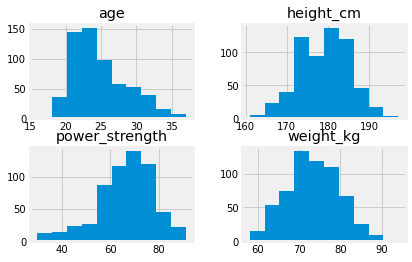

In [232]:


data[['age', 'height_cm', 'weight_kg', 'power_strength']].hist()


In [233]:
print("-------Percentage of Null values count------")
for feature in data.columns.values:
    print(feature,"-->",100*data[feature].isnull().sum()/len(data))


-------Percentage of Null values count------
sofifa_id --> 0.0
age --> 0.0
height_cm --> 0.0
weight_kg --> 0.0
attacking_crossing --> 0.0
attacking_finishing --> 0.0
attacking_heading_accuracy --> 0.0
attacking_short_passing --> 0.0
attacking_volleys --> 0.0
skill_dribbling --> 0.0
skill_curve --> 0.0
skill_fk_accuracy --> 0.0
skill_long_passing --> 0.0
skill_ball_control --> 0.0
movement_acceleration --> 0.0
movement_sprint_speed --> 0.0
movement_agility --> 0.0
movement_reactions --> 0.0
movement_balance --> 0.0
power_shot_power --> 0.0
power_jumping --> 0.0
power_stamina --> 0.0
power_strength --> 0.0
power_long_shots --> 0.0
mentality_aggression --> 0.0
mentality_interceptions --> 0.0
mentality_positioning --> 0.0
mentality_vision --> 0.0
mentality_penalties --> 0.0
mentality_composure --> 0.0
defending_marking --> 0.0
defending_standing_tackle --> 0.0
defending_sliding_tackle --> 0.0
goalkeeping_diving --> 0.0
goalkeeping_handling --> 0.0
goalkeeping_kicking --> 0.0
goalkeeping_po

lots of missing features, but most still have atleast 35% values, so we will not be
removing any full features

In [234]:
# Drop the columns/rows where all elements are nan:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, inplace=True)  # For future should instead impute these

# Step 2: shall I standardise the data?
# What is the magnitude of data range?
# Only numerical variables needs to be scaled because catagorical variable cannot be scaled

num_col = data.select_dtypes(include=np.number).columns.tolist()
num_col.remove('sofifa_id')

In [235]:
# for i in num_col:
#     data[i] = preprocessing.StandardScaler().fit_transform(data[[i]])

Onto clustering, explain why not kmean or kmode - mixed data type
explain algo


In [236]:
X = data[data.columns.values[1:]].values
cat_col = list(set(data.columns) - set(num_col))
cat_col.remove('sofifa_id')
cat_col = sorted([data.columns.get_loc(c) - 1 for c in cat_col if c in data])


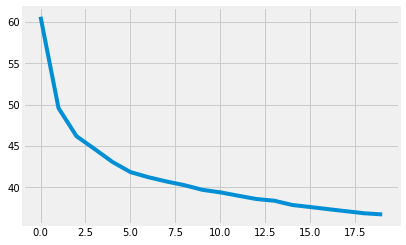

In [237]:
# X2 = X[np.random.choice(len(X), size=300, replace=True,)]
#Choosing optimal K
cost = []
for num_clusters in list(range(1,21)):
    kmn = KMeans(n_clusters=num_clusters)
    kmn.fit_predict(X)
    cost.append(sum(np.min(cdist(X, kmn.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

plt.plot(cost)

In [238]:
kmn = KMeans(n_clusters=5)
clusters = kmn.fit_predict(X)


In [239]:
data['Cluster'] = kmn.labels_

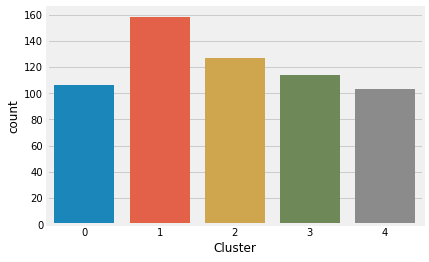

In [240]:
sns.countplot(x='Cluster', data = data)


Step 4: Dimensionality Reduction ###
Now we want to visualize the data from n diminesiton to 2 dimesion so we have to reduce the dimensionality of the
data.since our data has both categorical and numerical values so we have to use "factor analysis for mixed data" technique
"Prince" package has this implementation

In [241]:
pca = prince.PCA(n_components=2, copy=True, check_input=True, engine='auto', n_iter=10, rescale_with_mean=True, rescale_with_std=True)
pca = pca.fit(data.drop(columns=['sofifa_id','Cluster']))
pca.row_coordinates(data.drop(columns=['sofifa_id','Cluster']))

,0,1
0,-10.838005,0.215108
1,-7.190443,-6.467484
2,-6.598744,-3.701581
3,0.205770,-3.420727
4,1.652341,-6.464604
...,...,...
603,1.766395,4.329493
604,7.041760,9.795388
605,8.638956,9.655253
606,8.452732,7.215522


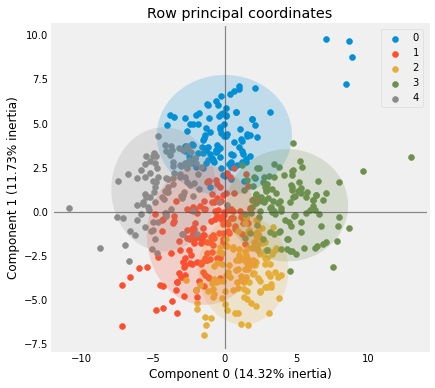

In [242]:
ax = pca.plot_row_coordinates(data.drop(columns=['sofifa_id','Cluster']), ax=None, x_component=0, y_component=1, ellipse_outline=False,
                               ellipse_fill=True, show_points=True, color_labels=data['Cluster'])





In [243]:
# # Step 5: profile the clusters (for a target variable)
# data.groupby('Cluster')['Rx'].mean().reset_index()
data = pd.merge(left=data, right=player, how='left', on='sofifa_id')
data.to_csv(r'test.csv', index=False)

In [249]:
data.groupby('Cluster')['age'].mean().reset_index()

,Cluster,age
0,0,22.245283
1,1,25.468354
2,2,26.889764
3,3,22.947368
4,4,26.475728


In [250]:
data.groupby('Cluster')['overall'].mean().reset_index()

,Cluster,overall
0,0,71.783019
1,1,78.050633
2,2,78.929134
3,3,72.868421
4,4,79.873786


In [253]:
data[data['Cluster'] == 4].describe()

,sofifa_id,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,trait_Leadership,trait_Long Shot Taker (CPU AI Only),trait_Long Throw-in,trait_Power Free-Kick,trait_Selfish,trait_Skilled Dribbling,trait_Speed Dribbler (CPU AI Only),Cluster,overall,potential
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,...,103.0,103.0,103.000000,103.00000,103.000000,103.0,103.000000,103.0,103.000000,103.000000
mean,203758.291262,26.475728,177.359223,72.252427,76.019417,74.194175,53.834951,78.213592,71.524272,82.077670,...,0.0,0.0,0.067961,0.07767,0.300971,0.0,0.009709,4.0,79.873786,82.592233
std,32385.761768,4.028926,5.590353,5.540791,6.073053,5.289757,11.081779,4.847984,6.690416,4.538915,...,0.0,0.0,0.252910,0.26896,0.460923,0.0,0.098533,0.0,3.607399,3.687384
min,20775.000000,18.000000,163.000000,59.000000,64.000000,62.000000,30.000000,68.000000,57.000000,71.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,4.0,73.000000,77.000000
25%,189115.000000,23.500000,173.500000,68.000000,72.000000,70.500000,45.500000,75.000000,68.000000,80.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,4.0,78.000000,80.000000
50%,207734.000000,26.000000,178.000000,73.000000,76.000000,74.000000,53.000000,78.000000,72.000000,82.000000,...,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,4.0,79.000000,82.000000
75%,226053.500000,29.500000,181.000000,75.000000,81.000000,77.000000,61.000000,81.500000,76.000000,85.000000,...,0.0,0.0,0.000000,0.00000,1.000000,0.0,0.000000,4.0,82.000000,86.000000
max,244369.000000,37.000000,193.000000,92.000000,91.000000,89.000000,78.000000,92.000000,90.000000,96.000000,...,0.0,0.0,1.000000,1.00000,1.000000,0.0,1.000000,4.0,92.000000,92.000000


In [254]:
data[data['Cluster'] == 0].describe()

,sofifa_id,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,trait_Leadership,trait_Long Shot Taker (CPU AI Only),trait_Long Throw-in,trait_Power Free-Kick,trait_Selfish,trait_Skilled Dribbling,trait_Speed Dribbler (CPU AI Only),Cluster,overall,potential
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,...,106.000000,106.0,106.000000,106.000000,106.000000,106.000000,106.000000,106.0,106.000000,106.000000
mean,230066.858491,22.245283,175.198113,69.518868,65.132075,65.613208,49.707547,69.198113,57.858491,74.754717,...,0.009434,0.0,0.009434,0.028302,0.235849,0.009434,0.009434,0.0,71.783019,79.858491
std,12859.260682,2.036857,5.697819,5.467185,6.839765,6.970100,9.337040,5.526421,8.569535,6.787680,...,0.097129,0.0,0.097129,0.166622,0.426545,0.097129,0.097129,0.0,4.848180,5.105438
min,172049.000000,16.000000,161.000000,58.000000,39.000000,38.000000,30.000000,44.000000,36.000000,42.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,49.000000,53.000000
25%,224517.250000,21.000000,171.000000,66.000000,62.000000,63.000000,43.000000,67.000000,52.250000,73.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,70.000000,78.000000
50%,233256.000000,22.000000,175.000000,70.000000,65.000000,66.500000,49.000000,70.000000,59.000000,76.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,72.000000,80.000000
75%,239903.500000,24.000000,180.000000,72.750000,69.000000,70.000000,55.750000,72.000000,65.000000,78.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,74.000000,83.000000
max,247000.000000,32.000000,190.000000,87.000000,80.000000,79.000000,75.000000,83.000000,75.000000,87.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,80.000000,87.000000
